In [159]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.datasets import fetch_mldata
from shutil import copyfileobj
from six.moves import urllib
from sklearn.datasets.base import get_data_home
import os
import random
import pandas as pd
import time

## Importing The Data

The below code for importing the entire MNIST dataset was provided by the instructor in a class slack channel.
The fetch_mldata function is depreceated, but still works for now.

The MNIST data set is a set of integers drawn by humans. Each data point has the drawing and the correct integer label.

In [143]:
def fetch_mnist(data_home=None):
    mnist_alternative_url = "https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat"
    data_home = get_data_home(data_home=data_home)
    data_home = os.path.join(data_home, 'mldata')
    if not os.path.exists(data_home):
        os.makedirs(data_home)
    mnist_save_path = os.path.join(data_home, "mnist-original.mat")
    if not os.path.exists(mnist_save_path):
        mnist_url = urllib.request.urlopen(mnist_alternative_url)
        with open(mnist_save_path, "wb") as matlab_file:
            copyfileobj(mnist_url, matlab_file)

fetch_mnist()
mnist = fetch_mldata("MNIST original")

/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22
  warnings.warn(msg, category=DeprecationWarning)


## Prepping the Data

To prepare the data set, I selected only the 3s and 7s, and converted the data into numpy arrays.

In [173]:
image = []
target = []

for i in range(len(mnist['target'])):
    if mnist['target'][i] == 3 or mnist['target'][i] == 7:
        image.append(mnist['data'][i])
        target.append(mnist['target'][i])
        
image_array = np.array(image)
target_array = np.array(target)

Each data point is an array of 738 pixels, with a greyscale value (indicating how black the pixel is). In order to visualize them, we must reshape the data into a 28 x 28 array. The 738 x 1 array is the correct format for using our classifier. The visualizations below show two drawings each for 3 and 7. 

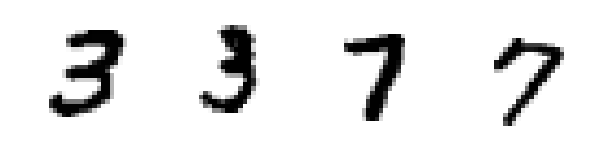

In [135]:
# Reshape the data for showing the integer drawing with matplotlib
display =[image_array[i].reshape(28,28) for i in [0,1,-1,-2]]

plt.figure(figsize = (10,6) )
for index, image in enumerate(display):
    plt.subplot(2, 4, index + 1)
    plt.axis('off')
    plt.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    

## Model Selection

I will be using a Support Vector Machine (SVM) to classify. SVMs offer several benefits for this situation.  Firstly, they are effective in high dimensional spaces. Image classification is high dimensional as we are looking at each indiviudal pixel. Secondly, we have the ability to choose different kernel functions. These kernel functions bring our data into even higher dimensions in order to find better classifiers. We will try three kernel functions (linear, polynomial, and radial basis function) to find which one performs best.


### Tuning Hyperparameters

We will tune the hyperparamters of our SVM using cross validation. We create a list of possible parameters and use Grid Search to find the optimal params. We are optimzing over several parameters. The first is C, the regularization parameter. This value acts as a penalty for misclassifcation, with a low c giving a low penalty and a high c giving a high penalty. This is applicable to all 3 kernels. The second parameter we are optimizing is just for the polynomial kernel and is the degree. This changes the number and type of additonal dimensions the kernel has. The third parameter is gamma, which is just for the rbf kernel. The gamma changes the variance of the rbf kernels, with a larger gamma, the radial basis functions narrow and can adapt more to the data. However, if it is too high it can lead to overfitting.



In [174]:
# Split the data into training and test set
X_train,X_test,y_train,y_test = train_test_split(image_array,target_array,test_size=0.25)

In [178]:
# Set the parameters to be optimized
param_grids = [
    {'kernel': ['linear'], 'C':[0.01, 0.1, 1, 10, 100]},
    {'kernel': ['poly'], 'C':[0.01, 0.1, 1, 10, 100], 'degree': [2,3,4]},
    {'kernel': ['rbf'], 'C':[0.01, 0.1, 1, 10, 100], 'gamma':[1e-8,1e-7,1e-6]}
    ]

# Run Grid Search
search = GridSearchCV(svm.SVC(), param_grids, cv=3, verbose = 10, n_jobs=-1)
search.fit(X_train, y_train)
print(search.best_score_)
print(search.best_params_)

Fitting 3 folds for each of 35 candidates, totalling 105 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   14.7s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   32.0s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   45.6s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done  93 out of 105 | elapsed:  7.3min remaining:   56.8s
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed:  8.4min finished


0.9958429561200923
{'C': 10, 'gamma': 1e-07, 'kernel': 'rbf'}


The best performing kernel was the rbf kernel with C = 10 and gamma = 1e-7 . However, we would like to see what the best paramaters for the other kernels were as well. 

In [180]:
df = pd.DataFrame(search.cv_results_)
df = df[['params','param_kernel','mean_test_score','rank_test_score']]
df.loc[df['param_kernel'] == 'linear']

,params,param_kernel,mean_test_score,rank_test_score
0,"{'C': 0.01, 'kernel': 'linear'}",linear,0.981801,26
1,"{'C': 0.1, 'kernel': 'linear'}",linear,0.981801,26
2,"{'C': 1, 'kernel': 'linear'}",linear,0.981801,26
3,"{'C': 10, 'kernel': 'linear'}",linear,0.981801,26
4,"{'C': 100, 'kernel': 'linear'}",linear,0.981801,26


We can see that changing the C value had no impact on our linear kernel. Thus, choosing a C of 1 will give us the optimal SVM with a linear kernel.

In [182]:
df.loc[df['param_kernel'] == 'poly']

,params,param_kernel,mean_test_score,rank_test_score
5,"{'C': 0.01, 'degree': 2, 'kernel': 'poly'}",poly,0.995566,3
6,"{'C': 0.01, 'degree': 3, 'kernel': 'poly'}",poly,0.994734,8
7,"{'C': 0.01, 'degree': 4, 'kernel': 'poly'}",poly,0.994088,16
8,"{'C': 0.1, 'degree': 2, 'kernel': 'poly'}",poly,0.995566,3
9,"{'C': 0.1, 'degree': 3, 'kernel': 'poly'}",poly,0.994734,8
10,"{'C': 0.1, 'degree': 4, 'kernel': 'poly'}",poly,0.994088,16
11,"{'C': 1, 'degree': 2, 'kernel': 'poly'}",poly,0.995566,3
12,"{'C': 1, 'degree': 3, 'kernel': 'poly'}",poly,0.994734,8
13,"{'C': 1, 'degree': 4, 'kernel': 'poly'}",poly,0.994088,16
14,"{'C': 10, 'degree': 2, 'kernel': 'poly'}",poly,0.995566,3


We can see that C had no impact on the polynomial kernel, but the degree did. The optimal poylnomial kernel has C=1, and degree = 3.

## Model Training and Results

### Linear Kernel

In [183]:
clf = svm.SVC(kernel = 'linear', C=1)
start = time.time()
clf.fit(X_train,y_train )
end = time.time()
print ('It took {0} seconds to train.'.format(round(end - start,2)))

# Make predictions on the test data
y_pred = (clf.predict(X_test))

# Show the results
print (metrics.classification_report(y_test, y_pred))

It took 6.37 seconds to train.
              precision    recall  f1-score   support

         3.0       0.98      0.98      0.98      1816
         7.0       0.98      0.97      0.98      1793

   micro avg       0.98      0.98      0.98      3609
   macro avg       0.98      0.98      0.98      3609
weighted avg       0.98      0.98      0.98      3609



### Polynomial Kernel

(The warning explained that the default setting of gamma (different than the gamma of the RBF) will change in the future, but we are fine for now)

In [186]:
clf = svm.SVC(kernel = 'poly', C=0.01, degree =3)
start = time.time()
clf.fit(X_train,y_train )
end = time.time()
print ('It took {0} seconds to train.'.format(round(end - start,2)))

# Make predictions on the test data
y_pred = (clf.predict(X_test))

# Show the results
print (metrics.classification_report(y_test, y_pred))

/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


It took 4.68 seconds to train.
              precision    recall  f1-score   support

         3.0       1.00      1.00      1.00      1816
         7.0       1.00      1.00      1.00      1793

   micro avg       1.00      1.00      1.00      3609
   macro avg       1.00      1.00      1.00      3609
weighted avg       1.00      1.00      1.00      3609



### RBF Kernel

In [185]:
clf = svm.SVC(kernel = 'rbf', C=10, gamma = 1e-07)
start = time.time()
clf.fit(X_train,y_train )
end = time.time()
print ('It took {0} seconds to train.'.format(round(end - start,2)))

# Make predictions on the test data
y_pred = (clf.predict(X_test))

# Show the results
print (metrics.classification_report(y_test, y_pred))

It took 4.87 seconds to train.
              precision    recall  f1-score   support

         3.0       1.00      0.99      1.00      1816
         7.0       0.99      1.00      1.00      1793

   micro avg       1.00      1.00      1.00      3609
   macro avg       1.00      1.00      1.00      3609
weighted avg       1.00      1.00      1.00      3609



### Results

Of the three kernels, the linear kernel took the longest to train at 6.37 seconds, with the polynomial time of 4.68 seconds beating the RBF time of 4.87. The linear kernel got a .98 accuracy overall, performing the worst. The Grid Search predicted that the RBF would perform the best, but in fact the polynomial kernel did slightly better. The weighted avg for both was 1.0, but the polynomial kernel actually got all of the correct, while the RBF kernel misclassifed at least one 3 as a 7. The results for the two were very close, but due to the slight accuracy increase and less training time, the polynomial kernel was the best for classfication of 3 and 7 MNIST digits.

## Classifcation on 3 classes

To extend this analysis, I performed classification with 3 classes. I got all data points for 3,7 and 2, and did the same cross validation optimization. To reduce the length of the cross validation, I took only half of the data set (ranomdally selected).

In [148]:
image = []
target = []

for i in range(len(mnist['target'])):
    if mnist['target'][i] == 3 or mnist['target'][i] == 7 or mnist['target'][i] == 2:
        if random.random() < 0.5:
            image.append(mnist['data'][i])
            target.append(mnist['target'][i])

        
image_array = np.array(image)
target_array = np.array(target)

X_train,X_test,y_train,y_test = train_test_split(image_array,target_array,test_size=0.25)

param_grids = [
    {'kernel': ['linear'], 'C':[0.01, 0.1, 1, 10, 100]},
    {'kernel': ['poly'], 'C':[0.01, 0.1, 1, 10, 100], 'degree': [2,3,4]},
    {'kernel': ['rbf'], 'C':[0.01, 0.1, 1, 10, 100], 'gamma':[1e-8,1e-7,1e-6]}
    ]

search = GridSearchCV(svm.SVC(), param_grids, cv=3, verbose = 10, n_jobs=-1)
search.fit(X_train, y_train)
print(search.best_score_)
print(search.best_params_)

Fitting 3 folds for each of 35 candidates, totalling 105 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   45.6s
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  61 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done  74 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done  93 out of 105 | elapsed:  7.4min remaining:   57.2s
[Parallel(n_jobs=-1)]: Done 105 out of 105 | elapsed:  8.7min finished
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid thi

0.9830193356470005
{'C': 0.01, 'degree': 3, 'kernel': 'poly'}


### Results

With 3 classes, the polynomial kernel with degree 3 performed the best, beating all potential rbf kernels. The model took slightly longer to train than the models with only 2 classes. The model performed at the level predicted by grid search, with a 0.98 avg overall.

In [172]:
clf = svm.SVC(kernel = 'poly', C=0.01, degree =3)
start = time.time()
clf.fit(X_train,y_train )
end = time.time()
print ('It took {0} seconds to train.'.format(round(end - start,2)))

# Make predictions on the test data
y_pred = (clf.predict(X_test))

# Show the results
print (metrics.classification_report(y_test, y_pred))

/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


It took 7.05 seconds to train.
              precision    recall  f1-score   support

         2.0       0.98      0.99      0.98       897
         3.0       0.99      0.98      0.98       886
         7.0       0.98      0.99      0.99       907

   micro avg       0.98      0.98      0.98      2690
   macro avg       0.98      0.98      0.98      2690
weighted avg       0.98      0.98      0.98      2690

